База- диалоги из фильма гениального фильма "Кин-Дза-Дза"

In [ ]:
from google.colab import files # модуль для загрузки файлов в colab
import numpy as np #библиотека для работы с массивами данных

from tensorflow.keras.models import Model, load_model # из кераса подгружаем абстрактный класс базовой модели, метод загрузки предобученной модели
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input # из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.optimizers import RMSprop, Adadelta # из кераса загружаем выбранный оптимизатор
from tensorflow.keras.preprocessing.sequence import pad_sequences # загружаем метод ограничения последовательности заданной длиной
from tensorflow.keras.preprocessing.text import Tokenizer # загружаем токенизатор кераса для обработки текста
from tensorflow.keras import utils # загружаем утилиты кераса для one hot кодировки
from tensorflow.keras.utils import plot_model # удобный график для визуализации архитектуры модели

import yaml # импортируем модуль для удобной работы с файлами

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Парсинг данных**

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/chatbot.txt", sep =';')

In [ ]:
data = np.array(data)

In [ ]:
data

array([['- - Они будут на карачках ползать, а мы на них плевать!'],
       ['  - А зачем?'],
       ['- - Как зачем удовольствие получать.'],
       ...,
       ['Скрипач?'],
       ['Дядя Вова?'],
       ['Скрипач...']], dtype=object)

In [ ]:
######################
# Разбираем вопросы-ответы с проставлением тегов ответам
######################
# Собираем вопросы и ответы в списки
questions = list() # здесь будет список вопросов
answers = list() # здесь будет список ответов

for i in range(len(data)): # для каждой пары вопрос-ответ
    if i%2==0:
      questions.append(data[i]) # то вопросительную реплику отправляем в список вопросов
    elif i%2 ==1:
      answers.append(data[i]) # а ответную в список ответов
answer = []
for i in range(len(answers)):
  answer.append( '<START> ' + answers[i] + ' <END>' )

In [ ]:
question = []
for i in range(len(questions)):
  temp = str(questions[i][0])
  question.append(temp)

In [ ]:
questions[i][0]

'Дядя Вова?'

In [ ]:
answers = []
for i in range(len(answer)):
  temp = str(answer[i][0])
  answers.append(temp)

In [ ]:
answer[i][0]

'<START> Скрипач... <END>'

In [ ]:
maxWordsCount = 2000

In [ ]:
######################
# Подключаем керасовский токенизатор и собираем словарь индексов
######################
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(question + answers) # загружаем в токенизатор список вопросов-ответов для сборки словаря частотности
vocabularyItems = list(tokenizer.word_index.items()) # список с cодержимым словаря
vocabularySize = len(vocabularyItems)+1 # размер словаря
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))
print( 'Размер словаря : {}'.format(vocabularySize))

Фрагмент словаря : [('unknown', 1), ('start', 2), ('end', 3), ('а', 4), ('ку', 5), ('не', 6), ('я', 7), ('и', 8), ('в', 9), ('что', 10), ('на', 11), ('ты', 12), ('у', 13), ('это', 14), ('вот', 15), ('ну', 16), ('мы', 17), ('так', 18), ('как', 19), ('нет', 20), ('вы', 21), ('скрипач', 22), ('с', 23), ('то', 24), ('родной', 25), ('он', 26), ('вас', 27), ('нас', 28), ('пацак', 29), ('за', 30), ('есть', 31), ('меня', 32), ('они', 33), ('кц', 34), ('надо', 35), ('ещё', 36), ('давай', 37), ('дядя', 38), ('тут', 39), ('тебя', 40), ('здесь', 41), ('там', 42), ('когда', 43), ('где', 44), ('из', 45), ('владимир', 46), ('николаевич', 47), ('кю', 48), ('тебе', 49), ('только', 50)]
Размер словаря : 1989


In [ ]:
dict_list = []
for  i in range(len(vocabularyItems)):
   dict_list.append(vocabularyItems[i][0])
print(dict_list)
print(len(dict_list)) 

['unknown', 'start', 'end', 'а', 'ку', 'не', 'я', 'и', 'в', 'что', 'на', 'ты', 'у', 'это', 'вот', 'ну', 'мы', 'так', 'как', 'нет', 'вы', 'скрипач', 'с', 'то', 'родной', 'он', 'вас', 'нас', 'пацак', 'за', 'есть', 'меня', 'они', 'кц', 'надо', 'ещё', 'давай', 'дядя', 'тут', 'тебя', 'здесь', 'там', 'когда', 'где', 'из', 'владимир', 'николаевич', 'кю', 'тебе', 'только', 'всё', 'если', 'ы', 'сейчас', 'вова', 'цак', 'же', 'пацаки', 'или', 'мне', 'два', 'кто', 'нам', 'чего', 'нибудь', 'мама', 'все', 'время', 'к', 'да', 'гравицаппу', 'по', 'планеты', 'гедеван', 'вам', 'значит', 'зачем', 'могу', 'она', 'их', 'спасибо', 'до', 'спичку', 'спички', 'раз', 'этот', 'спокойно', 'земля', 'от', 'во', 'пошли', 'может', 'землю', 'пж', 'штаны', 'ясно', 'нельзя', 'сами', 'эцих', 'его', 'бы', 'них', 'эцилопп', 'уэф', 'говорит', 'номер', 'одень', 'но', 'скрипку', 'друг', 'планета', 'сказал', 'гедевану', 'буду', 'такое', 'ыку', 'почему', 'сюда', 'чатланин', 'куда', 'будьте', 'любезны', 'можно', 'уже', 'для', 'п

In [ ]:
######################
# Устанавливаем закодированные входные данные(вопросы)
######################
tokenizedQuestions = tokenizer.texts_to_sequences(question) # разбиваем текст вопросов на последовательности индексов
maxLenQuestions = max([ len(x) for x in tokenizedQuestions]) # уточняем длину самого большого вопроса
# Делаем последовательности одной длины, заполняя нулями более короткие вопросы
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

# Предподготавливаем данные для входа в сеть
encoderForInput = paddedQuestions
print('Пример оригинального вопроса на вход : {}'.format(question[50])) 
print('Пример кодированного вопроса на вход : {}'.format(encoderForInput[50])) 
print('Размеры закодированного массива вопросов на вход : {}'.format(encoderForInput.shape)) 
print('Установленная длина вопросов на вход : {}'.format(maxLenQuestions)) 


Пример оригинального вопроса на вход :   - Вот ты и покажешь.
Пример кодированного вопроса на вход : [ 15  12   8 594   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Размеры закодированного массива вопросов на вход : (578, 42)
Установленная длина вопросов на вход : 42


In [ ]:
encoderForInput = encoderForInput[:]

In [ ]:
######################
# Устанавливаем раскодированные входные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
maxLenAnswers = max([len(x) for x in tokenizedAnswers]) # уточняем длину самого большого ответа
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Предподготавливаем данные для входа в сеть
decoderForInput = paddedAnswers # переводим в numpy массив
print('Пример оригинального ответа на вход: {}'.format(answers[50])) 
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[50][:30])) 
print('Размеры раскодированного массива ответов на вход : {}'.format(decoderForInput.shape)) 
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers)) 

Пример оригинального ответа на вход: <START> - - Пусть еще что-нибудь даст. <END>
Пример раскодированного ответа на вход : [   2  156 1448   10   65  464    3    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
Размеры раскодированного массива ответов на вход : (578, 47)
Установленная длина ответов на вход : 47


In [ ]:
######################
# Раскодированные выходные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
for i in range(len(tokenizedAnswers)) : # для разбитых на последовательности ответов
  tokenizedAnswers[i] = tokenizedAnswers[i][1:] # избавляемся от тега <START>
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post')

oneHotAnswers = utils.to_categorical(paddedAnswers, vocabularySize) # переводим в one hot vector
decoderForOutput = np.array(oneHotAnswers) # и сохраняем в виде массива numpy

In [ ]:
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[50][:21]))  
print('Пример раскодированного ответа на выход : {}'.format(decoderForOutput[50][4][:21])) 
print('Размеры раскодированного массива ответов на выход : {}'.format(decoderForOutput.shape))
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers)) 

Пример раскодированного ответа на вход : [   2  156 1448   10   65  464    3    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]
Пример раскодированного ответа на выход : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Размеры раскодированного массива ответов на выход : (578, 47, 1989)
Установленная длина вопросов на выход : 47


# **Параметры нейросети и модель обучения**

In [ ]:
######################
# Первый входной слой, кодер, выходной слой
######################
encoderInputs = Input(shape=(None , )) # размеры на входе сетки (здесь будет encoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
encoderEmbedding = Embedding(vocabularySize, 200 , mask_zero=True) (encoderInputs)
# Затем выход с Embedding пойдёт в LSTM слой, на выходе у которого будет два вектора состояния - state_h , state_c
# Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

In [ ]:
######################
# Второй входной слой, декодер, выходной слой
######################
decoderInputs = Input(shape=(None, )) # размеры на входе сетки (здесь будет decoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
# mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs) 
# Затем выход с Embedding пойдёт в LSTM слой, которому передаются вектора состояния - state_h , state_c
decoderLSTM = LSTM(200, return_state=True, return_sequences=True)
decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates)
# И от LSTM'а сигнал decoderOutputs пропускаем через полносвязный слой с софтмаксом на выходе
decoderDense = Dense(vocabularySize, activation='softmax') 
output = decoderDense (decoderOutputs)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 200)    397800      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 200)    397800      input_4[0][0]                    
____________________________________________________________________________________________

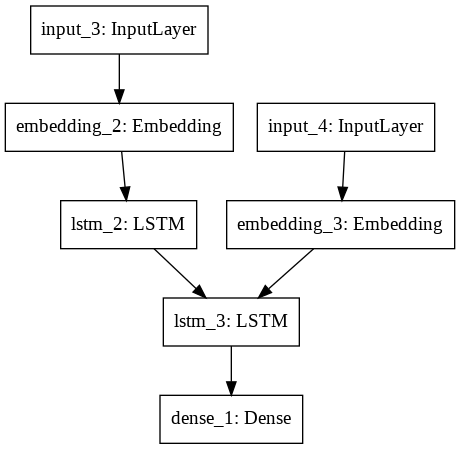

In [ ]:
######################
# Собираем тренировочную модель нейросети
######################
model = Model([encoderInputs, decoderInputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

print(model.summary()) # выведем на экран информацию о построенной модели нейросети
plot_model(model, to_file='model.png') # и построим график для визуализации слоев и связей между ними

In [ ]:
# Запустим обучение и сохраним модель
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=5, epochs=100) 
# model.save( '/content/drive/My Drive/Предобученные сети/model_100epochs(rms).h5' )

Epoch 1/100
116/116 [==============================] - 12s 14ms/step - loss: 1.1332
Epoch 2/100
116/116 [==============================] - 2s 14ms/step - loss: 1.0100
Epoch 3/100
116/116 [==============================] - 2s 14ms/step - loss: 0.8887
Epoch 4/100
116/116 [==============================] - 2s 15ms/step - loss: 0.9454
Epoch 5/100
116/116 [==============================] - 2s 16ms/step - loss: 0.9048
Epoch 6/100
116/116 [==============================] - 2s 16ms/step - loss: 0.8481
Epoch 7/100
116/116 [==============================] - 2s 16ms/step - loss: 0.7936
Epoch 8/100
116/116 [==============================] - 2s 17ms/step - loss: 0.8128
Epoch 9/100
116/116 [==============================] - 2s 16ms/step - loss: 0.8162
Epoch 10/100
116/116 [==============================] - 2s 15ms/step - loss: 0.7798
Epoch 11/100
116/116 [==============================] - 2s 14ms/step - loss: 0.7110
Epoch 12/100
116/116 [==============================] - 2s 14ms/step - loss: 0.7880


In [ ]:
model.compile(optimizer=Adadelta(), loss='categorical_crossentropy')

In [ ]:
# Запустим обучение и сохраним модель
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=5, epochs=50) 
# model.save( '/content/drive/My Drive/Предобученные сети/model_100epochs(rms) + 50(ada).h5' )

Epoch 1/50
116/116 [==============================] - 1s 13ms/step - loss: 0.0093
Epoch 2/50
116/116 [==============================] - 1s 12ms/step - loss: 0.0093
Epoch 3/50
116/116 [==============================] - 1s 12ms/step - loss: 0.0092
Epoch 4/50
116/116 [==============================] - 1s 12ms/step - loss: 0.0092
Epoch 5/50
116/116 [==============================] - 1s 12ms/step - loss: 0.0092
Epoch 6/50
116/116 [==============================] - 1s 12ms/step - loss: 0.0092
Epoch 7/50
116/116 [==============================] - 1s 12ms/step - loss: 0.0092
Epoch 8/50
116/116 [==============================] - 1s 12ms/step - loss: 0.0092
Epoch 9/50
116/116 [==============================] - 1s 13ms/step - loss: 0.0092
Epoch 10/50
116/116 [==============================] - 1s 12ms/step - loss: 0.0092
Epoch 11/50
116/116 [==============================] - 1s 13ms/step - loss: 0.0092
Epoch 12/50
116/116 [==============================] - 1s 12ms/step - loss: 0.0092
Epoch 13/50
1

# **Подготовка и запуск рабочей нейросети с генерацией ответов**

In [ ]:
######################
# Создаем рабочую модель для вывода ответов на запросы пользователя
######################
def makeInferenceModels():
  # Определим модель кодера, на входе далее будут закодированные вопросы(encoderForInputs), на выходе состояния state_h, state_c
  encoderModel = Model(encoderInputs, encoderStates) 

  decoderStateInput_h = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_h
  decoderStateInput_c = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_c

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # возьмем оба inputs вместе и запишем в decoderStatesInputs

  # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c] # LSTM даст нам новые состояния
  decoderOutputs = decoderDense(decoderOutputs) # и ответы, которые мы пропустим через полносвязный слой с софтмаксом

  # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
  # на выходе предсказываемый ответ и новые состояния
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

  return encoderModel , decoderModel

In [ ]:
######################
# Создадим функцию, которая преобразует вопрос пользователя в последовательность индексов
######################
def strToTokens(sentence: str): # функция принимает строку на вход (предложение с вопросом)
  words = sentence.lower().split() # приводит предложение к нижнему регистру и разбирает на слова
  # for word in words:
  #   if words in dict_list:
  #     continue
  #   else:  
  #     words == 'unknown'
  tokensList = list() # здесь будет последовательность токенов/индексов
  for word in words: # для каждого слова в предложении
    if word in dict_list:
      tokensList.append(tokenizer.word_index[word]) # определяем токенизатором индекс и добавляем в список
    # else:
    #   # tokensList.append(tokenizer.word_index['unknown'])  
    #   continue
    # Функция вернёт вопрос в виде последовательности индексов, ограниченной длиной самого длинного вопроса из нашей базы вопросов
  return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

In [ ]:
######################
# Устанавливаем окончательные настройки и запускаем модель
######################

encModel , decModel = makeInferenceModels() # запускаем функцию для построения модели кодера и декодера

for _ in range(10): # задаем количество вопросов, и на каждой итерации в этом диапазоне:
  # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  # Создаём пустой массив размером (1, 1)
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # положим в пустую последовательность начальное слово 'start' в виде индекса

  stopCondition = False # зададим условие, при срабатывании которого, прекратится генерация очередного слова
  decodedTranslation = '' # здесь будет собираться генерируемый ответ
  while not stopCondition : # пока не сработало стоп-условие
    # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
    # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    #argmax пробежит по вектору decOutputs'а[0,0,15104], найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
    sampledWordIndex = np.argmax( decOutputs[0, 0, :]) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова.
    sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
        sampledWord = word # выбранное слово фиксируем в переменную sampledWord
    
    # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию


    emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
    statesValues = [h, c] # и состояния, обновленные декодером
    # и продолжаем цикл с обновленными параметрами
  
  print(decodedTranslation[:-3]) # выводим ответ сгенерированный декодером

Задайте вопрос : привет
 как жизнь чего новенького на плюке 
Задайте вопрос : ну на плюке все нормально,зима,родной
 вот ты а вот гравицаппа ку 
Задайте вопрос : а зачем нужна гравицапа
 ну ку 
Задайте вопрос : что такое
 ну ыыыыы нас 
Задайте вопрос : расскажи историю
 а ты паршивый чатлан цак одень и sit down когда с пацаком разговариваешь хануд пацакская планета родной 
Задайте вопрос : вот как заговорил значит
 я не в 
Задайте вопрос : не в чем
 номер своего ку 
Задайте вопрос : я не знаю
 пока пацаки 
Задайте вопрос : ну до свидания
 сколько ты нам дашь если мы тебя туда положим 
Задайте вопрос : нисколько,это бесплатно
 ну что давай прощаться привык я к вам что ли 


# **Загрузка и запуск предобученной модели**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Подгружаем модель из файла и выведем её параметры
# model = load_model('/content/gdrive/My Drive/Предобученные сети/model_100epochs(rms) + 50(ada).h5')
#model = load_model('model_chatbot_100epochs(rms)+50(ada) (1).h5')
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 200)    397800      input_7[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 200)    397800      input_8[0][0]                    
____________________________________________________________________________________________

In [ ]:
######################
# Устанавливаем связи между слоями рабочей модели и предобученной
######################
def loadInferenceModels():
  encoderInputs = model.input[0]   # входом энкодера рабочей модели будет первый инпут предобученной модели(input_1)
  encoderEmbedding = model.layers[2] # связываем эмбединг слои(model.layers[2] это embedding_1)
  encoderOutputs, state_h_enc, state_c_enc = model.layers[4].output # вытягиваем аутпуты из первого LSTM слоя обуч.модели и даем энкодеру(lstm_1)
  encoderStates = [state_h_enc, state_c_enc] # ложим забранные состояния в состояния энкодера
  encoderModel = Model(encoderInputs, encoderStates) # формируем модель

  decoderInputs = model.input[1]   # входом декодера рабочей модели будет второй инпут предобученной модели(input_2)
  decoderStateInput_h = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_h
  decoderStateInput_c = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_c

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # возьмем оба inputs вместе и запишем в decoderStatesInputs

  decoderEmbedding = model.layers[3] # связываем эмбединг слои(model.layers[3] это embedding_2)
  decoderLSTM = model.layers[5] # связываем LSTM слои(model.layers[5] это lstm_2)
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding.output, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c] # LSTM даст нам новые состояния

  decoderDense = model.layers[6] # связываем полносвязные слои(model.layers[6] это dense_1)
  decoderOutputs = decoderDense(decoderOutputs) # выход с LSTM мы пропустим через полносвязный слой с софтмаксом

    # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
    # на выходе предсказываемый ответ и новые состояния
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)
  return encoderModel , decoderModel

In [ ]:
######################
# Устанавливаем окончательные настройки и запускаем рабочую модель над предобученной
######################

encModel , decModel = loadInferenceModels() # запускаем функцию для построения модели кодера и декодера

for _ in range(6): # задаем количество вопросов, и на каждой итерации в этом диапазоне:
  # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  # Создаём пустой массив размером (1, 1)
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # положим в пустую последовательность начальное слово 'start' в виде индекса

  stopCondition = False # зададим условие, при срабатывании которого, прекратится генерация очередного слова
  decodedTranslation = '' # здесь будет собираться генерируемый ответ
  while not stopCondition : # пока не сработало стоп-условие
    # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
    # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    #argmax пробежит по вектору decOutputs'а[0,0,15104], найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
    sampledWordIndex = np.argmax( decOutputs[0, 0, :]) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова.
    sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
        sampledWord = word # выбранное слово фиксируем в переменную sampledWord
    
    # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию

    emptyTargetSeq = np.zeros((1, 1)) # создаем пустой массив
    emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
    statesValues = [h, c] # и состояния, обновленные декодером
    # и продолжаем цикл с обновленными параметрами
  
  print(decodedTranslation) # выводим ответ сгенерированный декодером

Задайте вопрос : привет 
 как жизнь чего новенького на плюке end
Задайте вопрос : все хорошо, а как у вас?
 ку end
Задайте вопрос : и тебе ку
 ку end
Задайте вопрос : ладно,давай расскажи что-то новенькое
 ну что давай прощаться привык я к вам что ли end
Задайте вопрос : плохо дело,переобучился ты что ли
 вот в туалет end
Задайте вопрос : только не сеййчас 
 посмотри end


Вывод: данные для обучения  не были должным образом сформированы(тут диалог более,чем 2х людей, цитаты расположены в примерном порядке их следования в фильме, не всегда там реально вопрос-ответ). Очень интересно сделать такую базу по-правильному и обучить чатбота отвечать в стиле Кин-дза-дза.
